In [1]:
from ultralytics import YOLO #导入yolov8库

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os
import time

# 1. 设备配置
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [3]:
# 2. 强力数据增强 (解决背景识别问题的关键)
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224), # 随机裁剪
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(30),      # 随机旋转
        transforms.ColorJitter(brightness=0.3, contrast=0.3), # 颜色抖动
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
# 3. 加载数据 (请确认你的路径)
data_dir = r'D:\毕业论文\代码部分\datasets\images'
image_datasets = {
    'train': datasets.ImageFolder(os.path.join(data_dir, 'train', 'PlantVillage'), data_transforms['train']),
    'val': datasets.ImageFolder(os.path.join(data_dir, 'val'), data_transforms['val'])
}
# 创建数据加载器
dataloaders = {x: DataLoader(image_datasets[x], batch_size=32, shuffle=True) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
print(f"分类名称: {class_names}")

分类名称: ['Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato_healthy']


In [4]:
# 4. 构建模型 (全量微调模式)
model = models.mobilenet_v2(pretrained=True)
# 注意：这里不冻结参数，让所有层都参与学习
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, 2)
model = model.to(device)

# 5. 定义损失函数和低学习率优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5) # 极低学习率保护预训练特征

c:\Users\24796\.conda\envs\yolov8\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\24796\.conda\envs\yolov8\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
# 6. 训练函数 (带绘图数据记录)
def train_model(model, criterion, optimizer, num_epochs=15):
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            # 记录历史数据用于绘图
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    return model, history

In [6]:
# 7. 开始训练
trained_model, history = train_model(model, criterion, optimizer, num_epochs=15)

# 8. 保存模型
torch.save(trained_model.state_dict(), 'tomato_leaf_model_v2.pth')
print("New model saved!")

Epoch 1/15
----------
train Loss: 0.2721 Acc: 0.9266
val Loss: 0.0586 Acc: 0.9990
Epoch 2/15
----------
train Loss: 0.0602 Acc: 0.9909
val Loss: 0.0220 Acc: 0.9990
Epoch 3/15
----------
train Loss: 0.0286 Acc: 0.9940
val Loss: 0.0120 Acc: 0.9979
Epoch 4/15
----------
train Loss: 0.0217 Acc: 0.9964
val Loss: 0.0085 Acc: 0.9990
Epoch 5/15
----------
train Loss: 0.0171 Acc: 0.9961
val Loss: 0.0067 Acc: 0.9990
Epoch 6/15
----------
train Loss: 0.0117 Acc: 0.9977
val Loss: 0.0058 Acc: 0.9990
Epoch 7/15
----------
train Loss: 0.0096 Acc: 0.9979
val Loss: 0.0056 Acc: 0.9990
Epoch 8/15
----------
train Loss: 0.0078 Acc: 0.9987
val Loss: 0.0056 Acc: 0.9990
Epoch 9/15
----------
train Loss: 0.0077 Acc: 0.9979
val Loss: 0.0051 Acc: 0.9990
Epoch 10/15
----------
train Loss: 0.0078 Acc: 0.9977
val Loss: 0.0056 Acc: 0.9979
Epoch 11/15
----------
train Loss: 0.0100 Acc: 0.9966
val Loss: 0.0046 Acc: 0.9990
Epoch 12/15
----------
train Loss: 0.0078 Acc: 0.9974
val Loss: 0.0047 Acc: 0.9990
Epoch 13/15
-

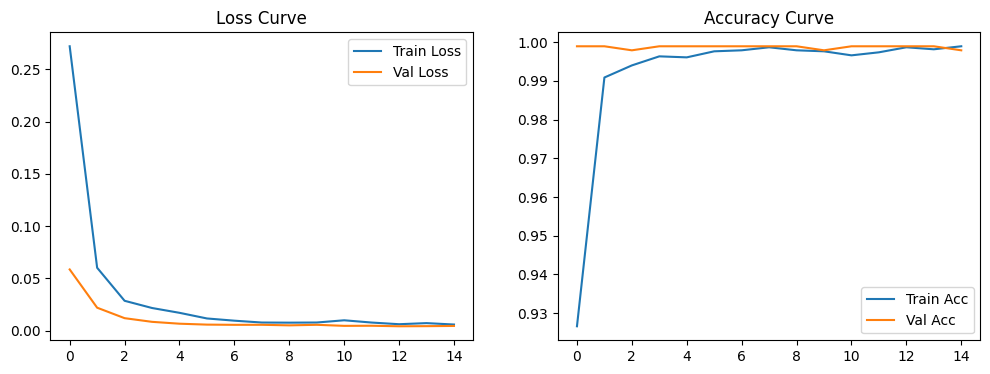

In [7]:
# 9. 绘制 Loss 和 Acc 曲线 
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Acc')
plt.plot(history['val_acc'], label='Val Acc')
plt.title('Accuracy Curve')
plt.legend()
plt.show()

In [1]:
# ==========================================
# 微调专用代码 (请确保你已经把错图扔进训练文件夹了！)
# ==========================================
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import os

# 1. 配置
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_dir = r'D:\毕业论文\代码部分\datasets\images'
model_path = 'tomato_leaf_model_v2.pth' # 加载旧模型

# 2. 数据准备 (和之前保持一致)
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(), # 再次随机翻转，让模型从不同角度看这两张新图
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# 重新加载数据集 (这次会包含你新塞进去的那几张图)
image_datasets = {
    'train': datasets.ImageFolder(os.path.join(data_dir, 'train', 'PlantVillage'), data_transforms['train']),
    'val': datasets.ImageFolder(os.path.join(data_dir, 'val'), data_transforms['val'])
}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=16, shuffle=True) for x in ['train', 'val']} # batch_size调小一点，专注细节
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

print("正在加载 v2 模型进行微调...")

# 3. 加载模型结构和权重
model = models.mobilenet_v2(pretrained=False) 
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, 2)
model.load_state_dict(torch.load(model_path, map_location=device))
model = model.to(device)

# 4. 设置极低的学习率 (Low Learning Rate)
# 为什么要低？因为模型已经很聪明了，只是有点小误解，不能改太猛
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9) 

# 5. 短暂训练 (5个Epoch足矣)
def finetune():
    for epoch in range(5): 
        print(f'Fine-tune Epoch {epoch+1}/5')
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print(f'  {phase} Acc: {epoch_acc:.4f}')
            
    return model

# 运行
model = finetune()
torch.save(model.state_dict(), 'tomato_leaf_model_v3.pth')
print("微调完成！模型已保存为 tomato_leaf_model_v3.pth")

正在加载 v2 模型进行微调...
Fine-tune Epoch 1/5


c:\Users\24796\.conda\envs\yolov8\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\24796\.conda\envs\yolov8\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


  train Acc: 0.9953
  val Acc: 0.9990
Fine-tune Epoch 2/5
  train Acc: 0.9912
  val Acc: 0.9979
Fine-tune Epoch 3/5
  train Acc: 0.9951
  val Acc: 0.9979
Fine-tune Epoch 4/5
  train Acc: 0.9956
  val Acc: 0.9979
Fine-tune Epoch 5/5
  train Acc: 0.9956
  val Acc: 0.9990
微调完成！模型已保存为 tomato_leaf_model_v3.pth


c:\Users\24796\.conda\envs\yolov8\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\24796\.conda\envs\yolov8\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


检测到旧模型，正在加载 tomato_leaf_model_v3.pth 权重继续训练...
开始 50 轮深度学习训练，请保持电脑电源连接...
Epoch 1/50
---------------
train Loss: 0.0098 Acc: 0.9971
val Loss: 0.0029 Acc: 0.9979
Epoch 2/50
---------------
train Loss: 0.0067 Acc: 0.9966
val Loss: 0.0035 Acc: 0.9979
Epoch 3/50
---------------
train Loss: 0.0067 Acc: 0.9979
val Loss: 0.0036 Acc: 0.9979
Epoch 4/50
---------------
train Loss: 0.0062 Acc: 0.9977
val Loss: 0.0018 Acc: 0.9990
Epoch 5/50
---------------
train Loss: 0.0054 Acc: 0.9982
val Loss: 0.0014 Acc: 1.0000
Epoch 6/50
---------------
train Loss: 0.0038 Acc: 0.9990
val Loss: 0.0018 Acc: 0.9990
Epoch 7/50
---------------
train Loss: 0.0068 Acc: 0.9979
val Loss: 0.0018 Acc: 1.0000
Epoch 8/50
---------------
train Loss: 0.0082 Acc: 0.9977
val Loss: 0.0013 Acc: 0.9990
Epoch 9/50
---------------
train Loss: 0.0060 Acc: 0.9979
val Loss: 0.0016 Acc: 1.0000
Epoch 10/50
---------------
train Loss: 0.0063 Acc: 0.9987
val Loss: 0.0018 Acc: 1.0000
Epoch 11/50
---------------
train Loss: 0.0066 Acc: 0.9

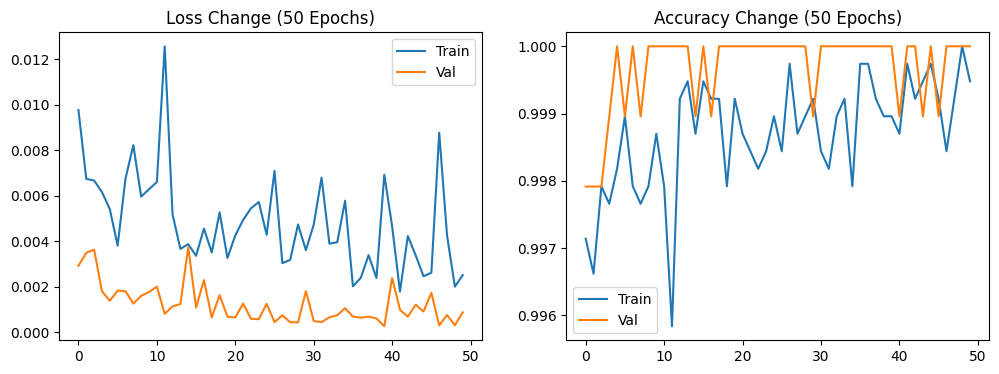

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os
import time

# 1. 基础配置
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_dir = r'D:\毕业论文\代码部分\datasets\images'
# 建议加载 v3 微调过的模型作为起点，也可以直接用预训练模型
start_model_path = 'tomato_leaf_model_v3.pth' 

# 2. 强力数据增强（确保模型不再死记硬背）
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(45),
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# 3. 加载数据集
image_datasets = {
    'train': datasets.ImageFolder(os.path.join(data_dir, 'train', 'PlantVillage'), data_transforms['train']),
    'val': datasets.ImageFolder(os.path.join(data_dir, 'val'), data_transforms['val'])
}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=32, shuffle=True) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

# 4. 构建模型（全参数开放）
model = models.mobilenet_v2(pretrained=True)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, 2)

# 如果 v3 模型存在，加载它作为基础
if os.path.exists(start_model_path):
    print(f"检测到旧模型，正在加载 {start_model_path} 权重继续训练...")
    model.load_state_dict(torch.load(start_model_path, map_location=device))

model = model.to(device)

# 5. 优化器设置（针对 50 轮训练，建议使用带衰减的学习率）
criterion = nn.CrossEntropyLoss()
# 使用较低的学习率，防止破坏已经学好的特征
optimizer = optim.Adam(model.parameters(), lr=1e-5) 

# 6. 训练核心逻辑
def train_deep_model(model, criterion, optimizer, num_epochs=50):
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 15)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())
                # 如果这个 epoch 的效果最好，可以单独标记
                if epoch_acc > best_acc:
                    best_acc = epoch_acc

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    return model, history

# 7. 开启漫长的训练（50轮）
print("开始 50 轮深度学习训练，请保持电脑电源连接...")
model_v4, history = train_deep_model(model, criterion, optimizer, num_epochs=50)

# 8. 保存最终模型
torch.save(model_v4.state_dict(), 'tomato_leaf_model_v4.pth')
print(f"训练完成！最强模型已保存为: tomato_leaf_model_v4.pth, 最高验证集准确率: {max(history['val_acc']):.4f}")

# 9. 自动绘制曲线图（论文必备）
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train')
plt.plot(history['val_loss'], label='Val')
plt.title('Loss Change (50 Epochs)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train')
plt.plot(history['val_acc'], label='Val')
plt.title('Accuracy Change (50 Epochs)')
plt.legend()
plt.show()